In [1]:
#Dependecies
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, CuDNNLSTM

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler

#setting the plot
%matplotlib inline
rcParams['figure.figsize'] = 14, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.5)


In [2]:
#Input Data
Data = pd.read_csv('/content/drive/My Drive/Dicoding/Submission/Submission_2/Coin_Ethereum.csv', parse_dates=['Date'])
Data

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Ethereum,ETH,2015-08-08 23:59:59,2.798810,0.714725,2.793760,0.753325,6.741880e+05,4.548689e+07
1,2,Ethereum,ETH,2015-08-09 23:59:59,0.879810,0.629191,0.706136,0.701897,5.321700e+05,4.239957e+07
2,3,Ethereum,ETH,2015-08-10 23:59:59,0.729854,0.636546,0.713989,0.708448,4.052830e+05,4.281836e+07
3,4,Ethereum,ETH,2015-08-11 23:59:59,1.131410,0.663235,0.708087,1.067860,1.463100e+06,6.456929e+07
4,5,Ethereum,ETH,2015-08-12 23:59:59,1.289940,0.883608,1.058750,1.217440,2.150620e+06,7.364501e+07
...,...,...,...,...,...,...,...,...,...,...
2155,2156,Ethereum,ETH,2021-07-02 23:59:59,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11
2156,2157,Ethereum,ETH,2021-07-03 23:59:59,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11
2157,2158,Ethereum,ETH,2021-07-04 23:59:59,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11
2158,2159,Ethereum,ETH,2021-07-05 23:59:59,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11


Sumber Data : https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory?select=coin_Ethereum.csv

In [3]:
#Drop Baris Kosong
Data.dropna(inplace=True)

#Mengambil data yang diperlukan
Harga = Data['Close'].values
Tanggal = Data['Date'].values

Text(0, 0.5, 'Harga (USD)')

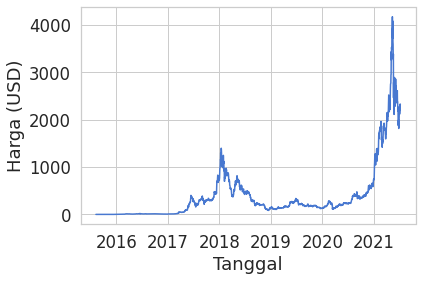

In [4]:
#Bentuk Plot Time Series
plt.plot(Tanggal, Harga)
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')

In [5]:
#Mengonvert Data menjadi Data yang diaccept Model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
#Membuat Model Sequensial
Model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*400)
])

In [9]:
#Split Dataset Yang Telah Dibuat
x_train, x_test, y_train, y_test = train_test_split(Harga, Tanggal, test_size = 0.2, random_state = 0, shuffle = False)

In [10]:
#Memwindowing Dataset
train_set = windowed_dataset(x_train, window_size=60, batch_size=120, shuffle_buffer=1200)
test_set = windowed_dataset(x_test, window_size=60, batch_size=120, shuffle_buffer=1200)

In [12]:
#Optimizer
Optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)

#Learning Rate dari Lamda
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

#Compile Model
Model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

In [16]:
#10% Syarat Dicoding MAE
m = 0.1*(Harga.max()-Harga.min())

print('Batas MAE =',m, 'Dollar')

Batas MAE = 416.8266219653342 Dollar


In [18]:
#Train Model
history = Model.fit(train_set ,epochs=30, validation_data= test_set)

Epoch 1/30
14/14 [==============================] - 36s 112ms/step - loss: 227.4663 - mae: 227.9663 - val_loss: 1272.2325 - val_mae: 1272.7325
Epoch 2/30
14/14 [==============================] - 0s 21ms/step - loss: 227.4562 - mae: 227.9562 - val_loss: 1272.2224 - val_mae: 1272.7224
Epoch 3/30
14/14 [==============================] - 0s 22ms/step - loss: 227.4461 - mae: 227.9461 - val_loss: 1272.2124 - val_mae: 1272.7124
Epoch 4/30
14/14 [==============================] - 0s 20ms/step - loss: 227.4360 - mae: 227.9360 - val_loss: 1272.2021 - val_mae: 1272.7021
Epoch 5/30
14/14 [==============================] - 0s 20ms/step - loss: 227.4259 - mae: 227.9259 - val_loss: 1272.1921 - val_mae: 1272.6921
Epoch 6/30
14/14 [==============================] - 0s 20ms/step - loss: 227.4158 - mae: 227.9158 - val_loss: 1272.1820 - val_mae: 1272.6820
Epoch 7/30
14/14 [==============================] - 0s 19ms/step - loss: 227.4058 - mae: 227.9058 - val_loss: 1272.1720 - val_mae: 1272.6720
Epoch 8/30


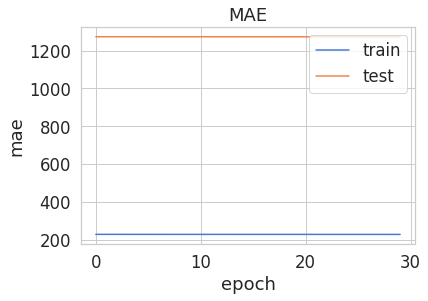

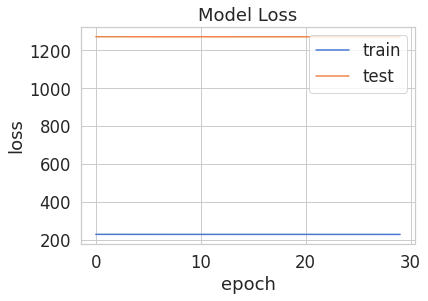

In [19]:
#Plot Model Train
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#Plot Model Test
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Model telah baik dan tidak melebihi batas 10% MAE, namun model terlihat overfitting sehingga saat digunakan di test set MAE lebih dari batas dan tidak baik.